In [1]:
# transformer plus elementary cellular automata
import torch
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
from torch.nn import functional as F
from eca import ECA

batch_size = 8
block_size = 32 # Has to be the square of grid_size to read the full grid
max_iter = 1000
epochs = 10
eval_interval = 500
learning_rate = 5e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embed = 64
n_head = 32
n_layer = 32
dropout = 0
text = []

# create dictionaries and then define unique characters for encoding and decoding
tokens = ['0', '1'] #, 's', 'e']

# Example usage with cellular automata
ca_width = 32  # Grid size for the cellular automata
step_count = 15  # Number of steps to evolve the cellular automata

vocab_size=len(tokens)
stoi = { ch:i for i, ch in enumerate(tokens)}
itos = { i:ch for i, ch in enumerate(tokens)}
enc = lambda s: [stoi[c] for c in s]
dec = lambda l: ''.join([itos[i] for i in l])

def generate_random_input_string(size):
    """Generate a random grid as a string for a given grid size."""
    return ''.join(np.random.choice(tokens, size))

def generate_game_of_life_sequence(batch_size, grid_size, step_count):
    """Generate a batch of 1D Cellular Automata initial states and final states."""
    initial_states = [generate_random_input_string(grid_size) for _ in range(batch_size)]
    final_states = []
    for state in initial_states:
        eca = ECA(grid_size)
        eca.set_initial_state(state)
        eca.run_simulation(step_count)
        final_state = eca.generations[-1]
        final_states.append(''.join(map(str, final_state)))  # Convert final state to string
    initial_states_with_tokens = [state for state in initial_states]
    return initial_states_with_tokens, final_states

# Define an appropriate size for your validation batch
val_batch_size = 20  

# load data
def get_batch(batch_size, grid_size, step_count, block_size):
    initial_states, final_states = generate_game_of_life_sequence(batch_size, grid_size, step_count)
    X = torch.tensor([enc(s)[:block_size] for s in initial_states], dtype=torch.long)
    Y = torch.tensor([enc(s)[:block_size] for s in final_states], dtype=torch.long)
    return X.to(device), Y.to(device)

# single head attention
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed,head_size,bias=False)
        self.query = nn.Linear(n_embed,head_size,bias=False)
        self.value = nn.Linear(n_embed,head_size,bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) *C**-0.5 # scaled attention
        # wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf')) # decoder block
        wei = F.softmax(wei,dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei@v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        out =  torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.proj(out) # Projection si the linear transformation of the outcome of prev layer
        return out

class SinusoidalActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)
        # return x + torch.sin(x) ** 2

class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed,4* n_embed), 
            # nn.ReLU(),
            nn.GELU(),
            # SinusoidalActivation(),
            nn.Linear(4* n_embed, n_embed),
            nn.Dropout(dropout),
            )
        self

    def forward(self,x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed //n_head
        self.sa = MultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
    
    def forward(self,x):
        x = x + self.sa(self.ln1(x)) # add x for residual connections
        x = x + self.ffwd(self.ln1(x))
        return x

class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size,n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed,n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed,vocab_size)
        self.apply(self._init_weights)
        self.position_embedding_table_x = nn.Embedding(ca_width, n_embed)
        self.position_embedding_table_y = nn.Embedding(ca_width, n_embed)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def lossy(self, output, target):
        output = output.view(target.shape)  # Reshape output to match target's shape
        return torch.mean((output != target).float())

    def hamming_loss(self, predictions, targets):
        # Ensure predictions are binary (0 or 1)
        predictions = predictions > 0.5
        # Calculate mismatches
        mismatches = torch.ne(predictions.float(), targets.float()).float()
        # Calculate the average number of mismatches
        return torch.mean(mismatches)

    def forward(self,idx,targets=None):
        B,T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device))
        x = tok_emb+pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        # print(f"logits are shape {logits.shape} are: {logits} for idx: {idx}")
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(-1, vocab_size)  # Reshape logits to [batch_size * block_size, vocab_size]
            targets = targets.view(-1,1)  # Flatten targets to [batch_size * block_size]
            targets = torch.cat((1 - targets, targets), dim=1)  
            # loss = self.lossy(logits, targets)
            # loss = F.cross_entropy(logits, targets)
            # predictions = torch.sigmoid(logits) > 0.5
            # loss = self.hamming_loss(predictions.view(-1), targets.view(-1))
            loss = F.binary_cross_entropy_with_logits(logits, targets.float(), reduction='mean')
            # loss = F.mse_loss(logits, F.one_hot(targets, num_classes=vocab_size).float())
            # print(f"logits are shape {logits.shape} are: {loss} for idx: {idx}")
        return logits, loss
    
    # def generate(self,idx,max_new_tokens):
    #     for _ in range(max_new_tokens):
    #         idx_cond = idx[:, -block_size:]
    #         logits, loss = self(idx_cond)
    #         logits = logits[:,-1,:]
    #         probs = F.softmax(logits,dim=-1)
    #         idx_next = torch.multinomial(probs,num_samples=1)
    #         idx=torch.cat((idx, idx_next), dim = 1)
    #     return idx
    
    # maintains a fixed decoder architecture while dynamically incorporating the model's output from the previous timestep into the next
    def generate(self, initial_idx, max_new_tokens):
        generated_idx = initial_idx
        for _ in range(max_new_tokens):
            # Only use the last `block_size` tokens as input to prevent exceeding model capacity
            idx_cond = generated_idx[:, -block_size:]
            
            # Generate logits for the next token
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]  # Take the logits for the last token position
            
            # Convert logits to probabilities and sample the next token
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            
            # Append the generated token to the input sequence for the next timestep
            generated_idx = torch.cat((generated_idx, idx_next), dim=1)
            
        return generated_idx

model = LanguageModel()
m = model.to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.5, centered=False)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.9, eps=1e-06, weight_decay=0.001)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=1, verbose=True)
loss = None  # Initialize loss variable outside the loop

for epoch in range(epochs):
    for iter in range(max_iter // epochs):  # Distribute iterations across epochs
        model.train()
        xb, yb = get_batch(batch_size, ca_width, step_count, block_size)
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        max_norm = 2
        # Clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        if iter % eval_interval == 0 and loss is not None:  # Validation logic
            model.eval()
            with torch.no_grad():
                xv, yv = get_batch(val_batch_size, ca_width, step_count, block_size)
                val_logits, val_loss = model(xv, yv)
                print(f"Epoch {epoch}, Iteration {iter}: Training Loss = {loss.item()}, Validation Loss = {val_loss.item()}")
            model.train()

    scheduler.step(val_loss)  # Update the learning rate at the end of each epoch

# Save:
torch.save(model, 'models/cat_eca_model_simple.pth')


Epoch 0, Iteration 0: Training Loss = 0.7007718086242676, Validation Loss = 0.7049564719200134
Epoch 1, Iteration 0: Training Loss = 0.6860789060592651, Validation Loss = 0.690703272819519
Epoch 2, Iteration 0: Training Loss = 0.6938973069190979, Validation Loss = 0.6825223565101624
Epoch 3, Iteration 0: Training Loss = 0.6794859766960144, Validation Loss = 0.6906839609146118
Epoch 4, Iteration 0: Training Loss = 0.6605228185653687, Validation Loss = 0.6775649785995483
Epoch 5, Iteration 0: Training Loss = 0.6769291758537292, Validation Loss = 0.6717867851257324
Epoch 6, Iteration 0: Training Loss = 0.6663895845413208, Validation Loss = 0.6718109250068665
Epoch 7, Iteration 0: Training Loss = 0.670649528503418, Validation Loss = 0.6714149117469788
Epoch 8, Iteration 0: Training Loss = 0.672381579875946, Validation Loss = 0.6707023978233337
Epoch 9, Iteration 0: Training Loss = 0.6826121807098389, Validation Loss = 0.6708499193191528


Input sequence is: 01000100010000101110101111111100
Generated from CA is: 11100100111100011110011100001100
Generated from T is: 01001011101100001100001111011011

Visualizing CA Generated Sequence:


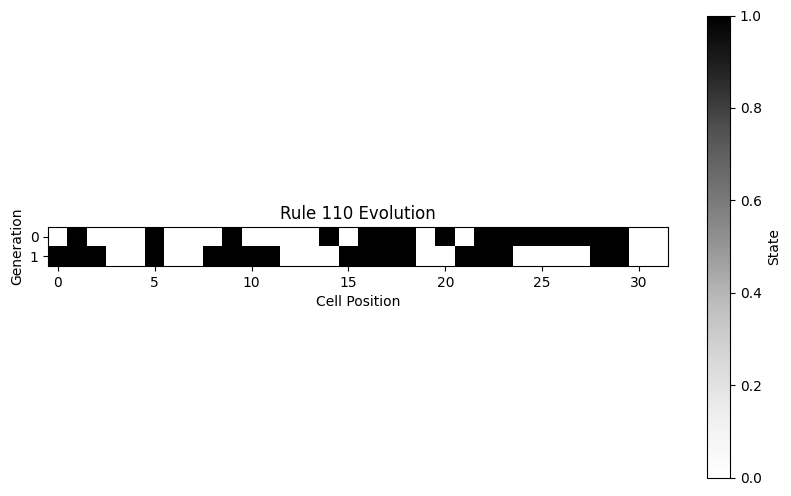

Visualizing Transformer Generated Sequence:


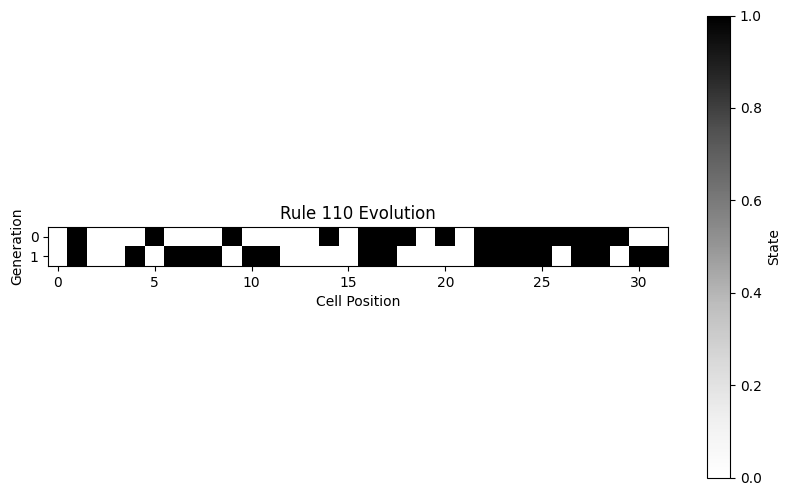

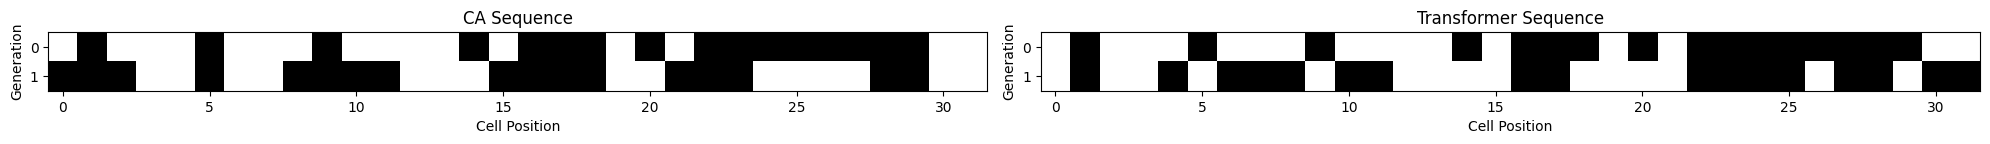

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from eca import ECA

model = torch.load('models/cat_eca_model_simple.pth')
model.eval()
input_length = 32
generations = 15
np.random.seed(42)  # Seed for reproducibility
input_sequence = ''.join(np.random.choice(tokens, input_length))
print(f"Input sequence is: {input_sequence}")
context = torch.tensor(enc(input_sequence), dtype=torch.long, device=device).unsqueeze(0)
output = model.generate(context, max_new_tokens=len(input_sequence))
generated_text_t = dec(output[0].tolist())
eca = ECA(input_length)
eca.set_initial_state(input_sequence)
eca.run_simulation(generations)
final_state = eca.generations[-1]
generated_text_ca = ''.join(map(str, final_state))

print(f"Generated from CA is: {generated_text_ca}")
print(f"Generated from T is: {(generated_text_t[len(input_sequence):])}\n")
input_state = [int(bit) for bit in input_sequence]
ca_generated_state = [int(bit) for bit in generated_text_ca]
t_generated_state = [int(bit) for bit in generated_text_t[len(input_sequence):]]
ca_sequence = [input_state, ca_generated_state]
t_sequence = [input_state, t_generated_state]

print("Visualizing CA Generated Sequence:")
eca.visualize(external_generations=ca_sequence)
print("Visualizing Transformer Generated Sequence:")
eca.visualize(external_generations=t_sequence)
eca.visualize_comparison(ca_sequence, t_sequence)
